In [1]:
!apt install libspatialindex-dev
!pip install osmnx
import numpy as np
import pandas as pd
import seaborn as sns
!pip uninstall matplotlib
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt
import IPython.display as disp
import osmnx as ox
import networkx as nx
from datetime import timedelta
from shapely.geometry import Polygon, LineString, Point
import itertools as iter
%matplotlib inline
ox.config(log_console=True)
ox.__version__




Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 2s (367 kB/s)
Selecting previously unselected package libspatialindex

Uninstalling matplotlib-3.4.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.4.2
     |████████████████████████████████| 13.1MB 328kB/s 
ERROR: osmnx 1.1.1 has requirement matplotlib>=3.3, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


'1.1.1'

In [21]:
def nsite_optimization(vacc, brgy, n = 3, graph_area = ("San Juan, Batangas, Philippines"),
                        distance = "road", return_distances = False):
  ##  N-site Optimization!!! ================================================================

  ## Select Open Street Map code for the given province 

  graph_area = graph_area

  # Create the graph of the area from OSM data. It will download the data and create the graph
  G = ox.graph_from_place(graph_area, network_type='drive')
  G = ox.add_edge_speeds(G)
  G = ox.add_edge_travel_times(G)


  ## Phase 1: N-site  Distance Matrix------------------------------------------------------------------
  index = vacc.Name
  columns = brgy.Barangay_name
  df_distances = pd.DataFrame(index=index, columns = columns)
  
  for i in vacc.index:
    for j in brgy.index:
      if distance == "road":
        #Get pure road distance
        origin_node = ox.distance.nearest_nodes(G, Y = brgy.iloc[j].latitude, X = brgy.iloc[j].longtitude)
        destination_node = ox.distance.nearest_nodes(G, Y = vacc.iloc[i].latitude, X = vacc.iloc[i].longtitude)
        
        df_distances.iloc[i,j] = nx.shortest_path_length(G, 
                                            origin_node, destination_node, weight='length')
      if distance == "euclidean":
        df_distances.iloc[i,j] = ox.distance.euclidean_dist_vec(
          vacc.iloc[i].latitude, vacc.iloc[i].longtitude, brgy.iloc[j].latitude, vacc.iloc[j].longtitude)

      if distance == "time":
        #Get pure road distance
        origin_node = ox.distance.nearest_nodes(G, Y = brgy.iloc[j].latitude, X = brgy.iloc[j].longtitude)
        destination_node = ox.distance.nearest_nodes(G, Y = vacc.iloc[i].latitude, X = vacc.iloc[i].longtitude)
        
        df_distances.iloc[i,j] = nx.shortest_path_length(G, 
                                            origin_node, destination_node, weight='travel_time')


  index1 = list(iter.combinations(df_distances.index, n))
  columns1 = brgy.Barangay_name
  master = pd.DataFrame(index=index1, columns = columns1)

  print("phase 1 complete")

  #Phase 2 ---------------------------------------------------------------------------

  for i, name in enumerate(list(iter.combinations(df_distances.index, n))):
      #print(i)
      for j in brgy.index:
        # Get weights
        weight = brgy["weight"][j]
        sads = [None]*n
        for k in np.arange(0,n):
          sads[k] = df_distances.loc[name[k]][j]
        master.iloc[i,j] = weight*min(sads)
  print("phase 2 complete")

  ## Display Best Vaccination centers! 
  results_nsite = pd.DataFrame(master.sum(axis=1))
  results_nsite.columns = ["C"]
  if return_distances is True:
    return results_nsite.sort_values(by=['C'], ascending=True), df_distances
  else:
    return results_nsite.sort_values(by=['C'], ascending=True) 

def site_distribution(results, df_distances):
    solution = df_distances.loc[[a for a in results.index[0]]]
    index = df_distances.columns
    columns = ["vaccination_center", "distance"]
    assignment  = pd.DataFrame(index=index, columns = columns)
    for i, name in enumerate(df_distances.columns):
      assignment.loc[name, "vaccination_center"] = solution.loc[:, [name]].sort_values(by=[name], ascending= True).index[0]
      assignment.loc[name, "distance"] = solution.loc[:, [name]].sort_values(by=[name], ascending=True).iloc[0, 0]
    
    distribution = assignment["vaccination_center"].value_counts()
    return assignment, distribution


def optimal_covid_sites(n = 3, vaccination_centers_df = 'Vaccination_Centers_Table.xlsx', barangays_df = 'Barangay_Centers_Table.xlsx',
                        graph_area = ("San Juan, Batangas, Philippines"),
                        distance = "road", return_distances = False, plot = True):
  ## Load Data ===============================================================================================
  vacc = pd.read_excel(vaccination_centers_df)
  brgy = pd.read_excel(barangays_df)
  TI = brgy.infected.sum()
  TP = brgy.population.sum() 
  brgy["weight"] = brgy.infected/TI + brgy.population/TP
  
  result_nsites, df_distances = nsite_optimization(vacc = vacc, brgy =brgy, n = n, graph_area = graph_area,
                                                   distance = distance, return_distances=True)
  assignment_nsite, distribution_nsite = site_distribution(results =  result_nsites, df_distances = df_distances)


  ## Plotting!!! =================================================================================================

  #Create the graph of the area from OSM data. 
  G = ox.graph_from_place(graph_area, network_type='drive')
  G = ox.add_edge_speeds(G)
  G = ox.add_edge_travel_times(G)

  ## Get coordinates of optimal sites
  optimal_sites = list(assignment_nsite.vaccination_center.unique())
  optimal_sites_loc = vacc[vacc.Name.isin(optimal_sites)] 
  optimal_sites_loc["colors"] = optimal_sites_loc["Name"].astype('category').cat.codes
  optimal_sites_loc

  # Get coordinates and assignments of barangays 
  wew = pd.merge(assignment_nsite, brgy, on = "Barangay_name")
  wew["colors"] = wew["vaccination_center"].astype('category').cat.codes
  wew = wew.rename(columns={'vaccination_center': 'assigned_vaccination_center'})


  plt.figure(figsize=(25, 17), dpi=1500)
  fig, ax = ox.plot_graph(G, edge_color = None, show=False, close=False, bgcolor = "white",
                          edge_linewidth=1, node_size=1, figsize=(25, 20), dpi = 20000)

  ax.scatter(wew.longtitude, wew.latitude, s= 100, c=wew["colors"], linewidths=1, edgecolors = "black", cmap='viridis')
  ax.scatter(optimal_sites_loc.longtitude, optimal_sites_loc.latitude, s = 800, edgecolors = "black",
            c=optimal_sites_loc["colors"], linewidths=2, marker = "*")
  plt.show()
  print(type(fig), type(ax))
  print(distribution_nsite)

  return assignment_nsite




phase 1 complete
phase 2 complete


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 37500x25500 with 0 Axes>

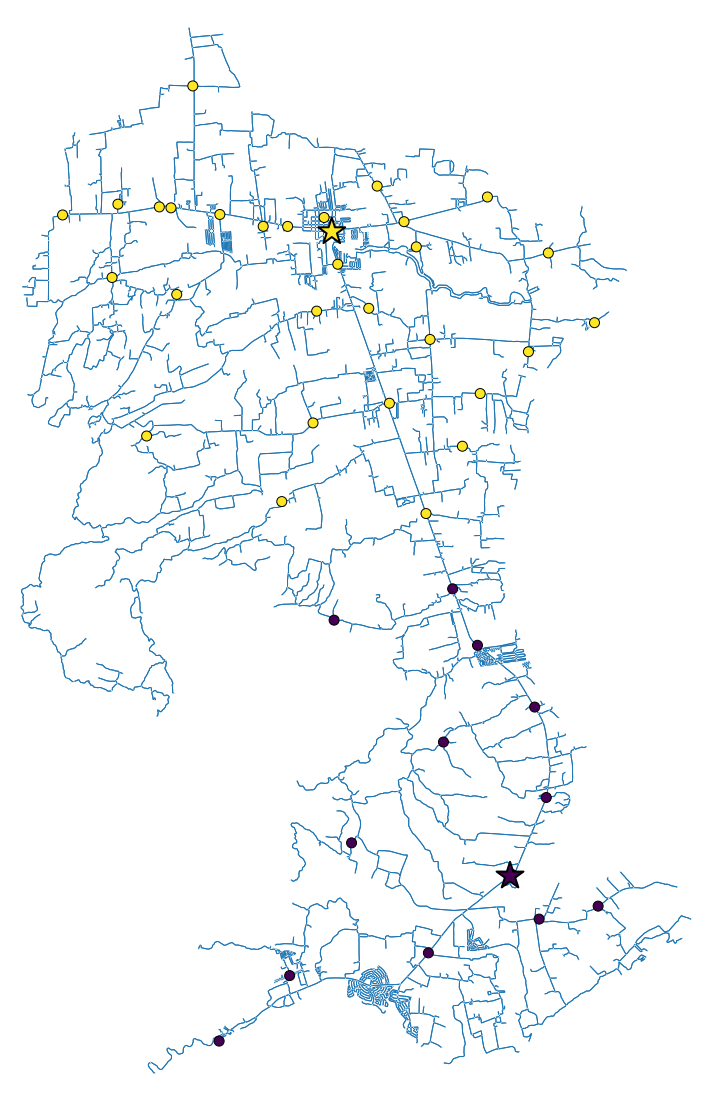

<class 'matplotlib.figure.Figure'> <class 'matplotlib.axes._subplots.AxesSubplot'>
San Juan Rural Health Unit I       29
Paaralang Elementarya ng Bataan    13
Name: vaccination_center, dtype: int64


In [22]:
results = optimal_covid_sites(n = 2, vaccination_centers_df = 'Vaccination_Centers_Table.xlsx', barangays_df = 'Barangay_Centers_Table.xlsx',
                        graph_area = ("San Juan, Batangas, Philippines"),
                        distance = "road", return_distances = False, plot = True)


In [23]:
results

,vaccination_center,distance
Barangay_name,,
Abung,San Juan Rural Health Unit I,6692.14
Balagbag,San Juan Rural Health Unit I,4064.3
Barualte,Paaralang Elementarya ng Bataan,2693.79
Bataan,Paaralang Elementarya ng Bataan,0
Buhay Na Sapa,San Juan Rural Health Unit I,4115.14
Bulsa,Paaralang Elementarya ng Bataan,4552.73
Calicanto,San Juan Rural Health Unit I,1857.74
Calitcalit,San Juan Rural Health Unit I,1684.93
Calubcub I,Paaralang Elementarya ng Bataan,7485.98
